In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df = pd.read_csv('web_attacks_balanced_Random_Forest.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

df = df[['Average Packet Size',
         'Flow Bytes/s',
         'Max Packet Length',
         'Fwd Packet Length Mean',
         'Fwd IAT Min',
         'Total Length of Fwd Packets',
         'Flow IAT Mean',
         'Fwd IAT Std',
         'Fwd Packet Length Max',
         'Flow Packets/s',
         'Label']]



In [3]:
df.head()

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd IAT Std,Fwd Packet Length Max,Flow Packets/s,Label
0,63.50,1361963.190,79.0,32.0,1.0,64.0,54.333333,0.0,32.0,24539.87730,0
1,80.00,1359605.911,94.0,44.0,47.0,88.0,67.666667,0.0,44.0,19704.43350,0
2,63.50,1329341.317,79.0,32.0,1.0,64.0,55.666667,0.0,32.0,23952.09581,0
3,80.00,1373134.328,94.0,44.0,49.0,88.0,67.000000,0.0,44.0,19900.49751,0
4,94.25,2050314.465,112.0,51.0,3.0,102.0,53.000000,0.0,51.0,25157.23270,0


In [4]:
df.shape

(7267, 11)

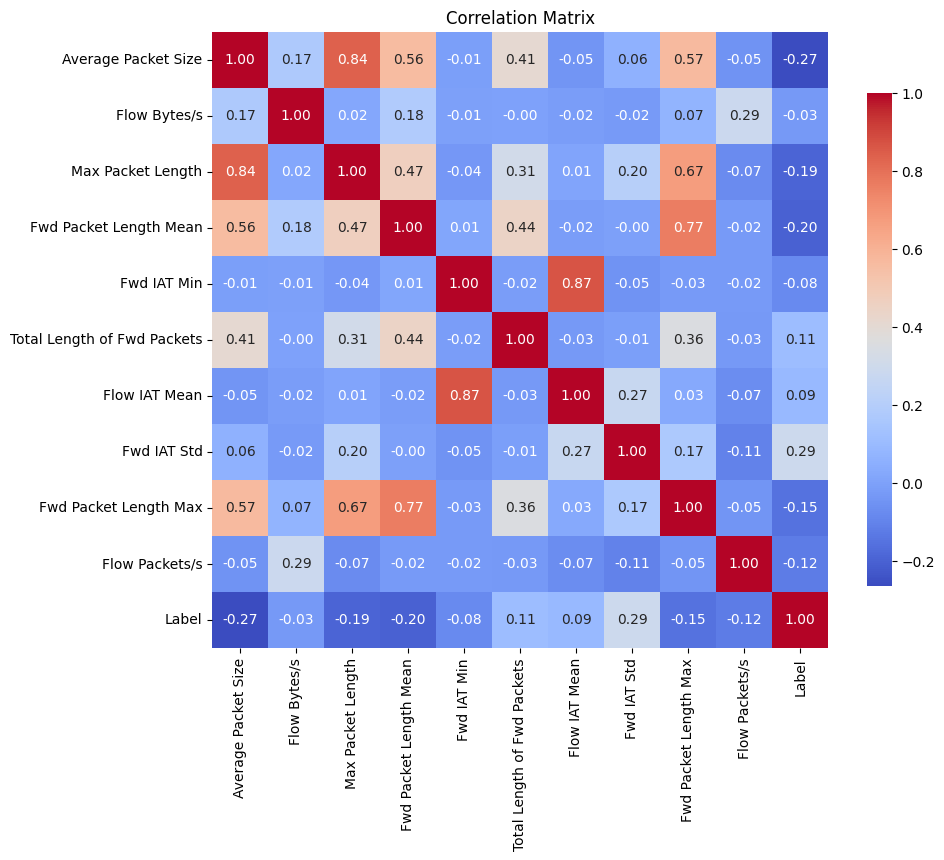

In [5]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

In [6]:
y = df['Label'].values
X = df.drop(columns=['Label']).values
print(X.shape, y.shape) 
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

(7267, 10) (7267,)


In [7]:
df.columns

Index(['Average Packet Size', 'Flow Bytes/s', 'Max Packet Length',
       'Fwd Packet Length Mean', 'Fwd IAT Min', 'Total Length of Fwd Packets',
       'Flow IAT Mean', 'Fwd IAT Std', 'Fwd Packet Length Max',
       'Flow Packets/s', 'Label'],
      dtype='object')

In [8]:
from tensorflow.keras.utils import to_categorical
# Convert labels to categorical format
y_cat = to_categorical(y, num_classes=2)
print(y_cat.shape)

/Users/hassanfarid/Documents/Rubab Project/Web Attack ML Project/Simulation/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


(7267, 2)


In [9]:
y_cat.shape

(7267, 2)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

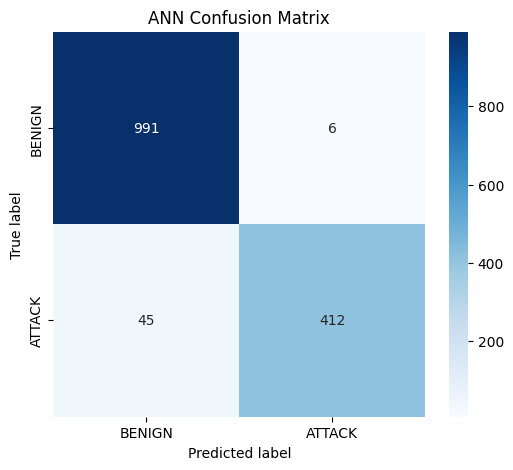

46/46 [==============================] - 0s 639us/step


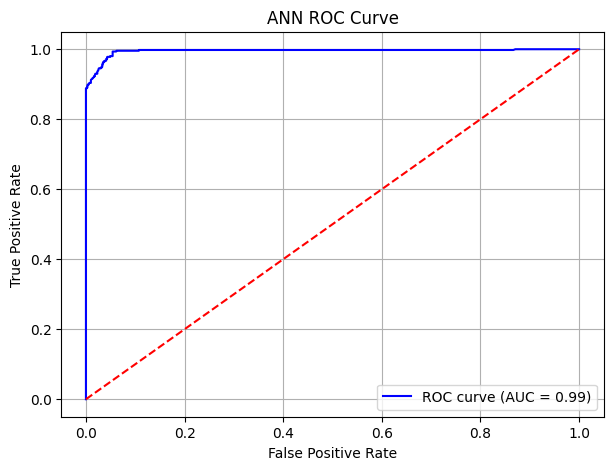

In [11]:
# ANN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build ANN model
ann_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
ann_model.summary()

# Train ANN
history_ann = ann_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate ANN
ann_loss, ann_acc = ann_model.evaluate(X_test, y_test, verbose=0)
print(f"ANN Test Accuracy: {ann_acc:.4f}")

# ANN predictions and metrics
y_pred_ann = ann_model.predict(X_test).argmax(axis=1)
y_true_ann = y_test.argmax(axis=1)

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

acc = accuracy_score(y_true_ann, y_pred_ann)
prec = precision_score(y_true_ann, y_pred_ann)
rec = recall_score(y_true_ann, y_pred_ann)
f1 = f1_score(y_true_ann, y_pred_ann)
report = classification_report(y_true_ann, y_pred_ann)

print(f"""
ANN Model Evaluation Metrics:
-----------------------------
Accuracy : {acc:.4f}
Precision: {prec:.4f}
Recall   : {rec:.4f}
F1 Score : {f1:.4f}

Classification Report:
{report}
""")

# Plot confusion matrix
cm = confusion_matrix(y_true_ann, y_pred_ann)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.title('ANN Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot ROC AUC
# For ROC, use the probability for the positive class
ann_probs = ann_model.predict(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_true_ann, ann_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

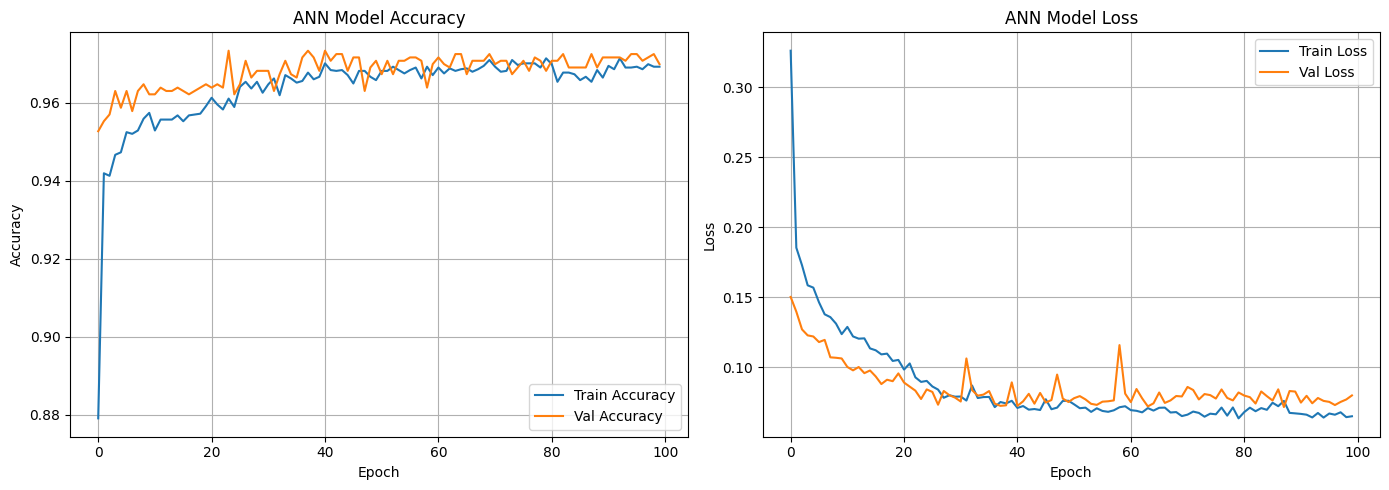

In [12]:
import matplotlib.pyplot as plt

# Plot ANN training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Val Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='Train Loss')
plt.plot(history_ann.history['val_loss'], label='Val Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 256)            273408    
                                                                 
 dropout_19 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_13 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dropout_20 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 128)              

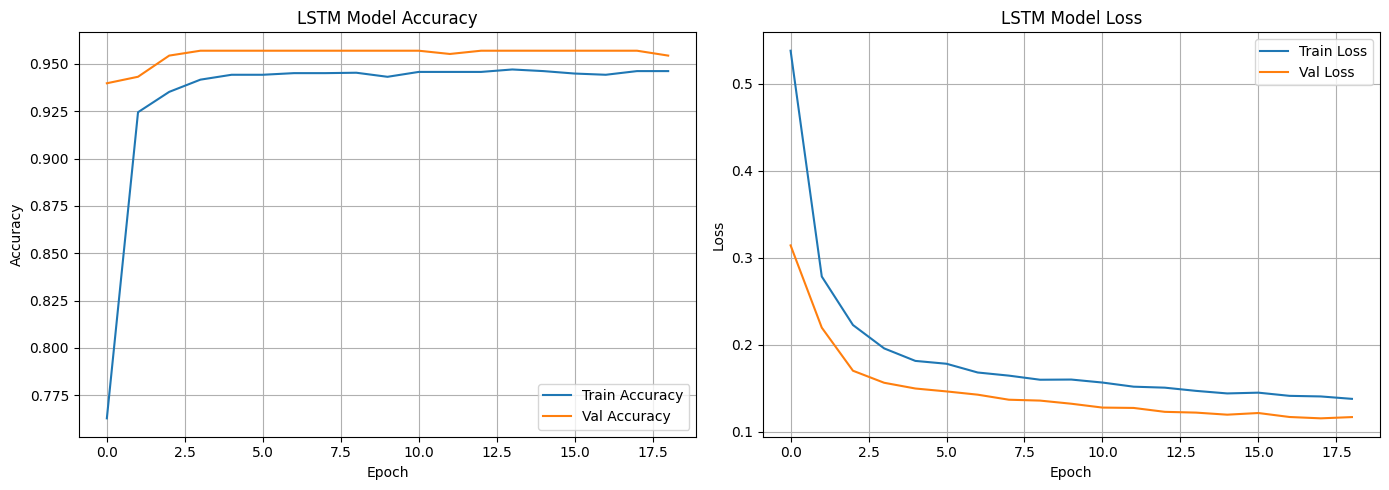

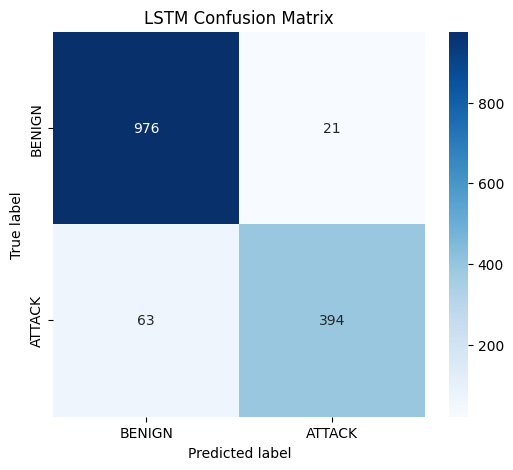

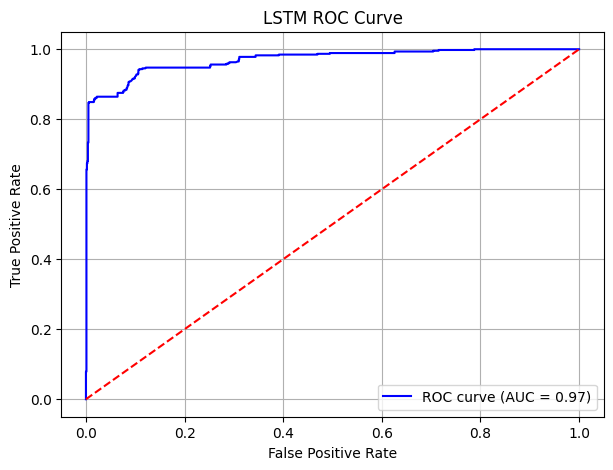

In [18]:
# LSTM Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Reshape for LSTM: (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
model_ckpt = ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True)

# Build a deeper LSTM model
lstm_model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train LSTM
history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, model_ckpt]
)

# Evaluate LSTM
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"LSTM Test Accuracy: {lstm_acc:.4f}")

# LSTM predictions and metrics
y_pred_lstm_prob = lstm_model.predict(X_test_lstm)
y_pred_lstm = y_pred_lstm_prob.argmax(axis=1)
y_true = y_test.argmax(axis=1)

acc = accuracy_score(y_true, y_pred_lstm)
prec = precision_score(y_true, y_pred_lstm)
rec = recall_score(y_true, y_pred_lstm)
f1 = f1_score(y_true, y_pred_lstm)
report = classification_report(y_true, y_pred_lstm)

print(f"""
LSTM Model Evaluation Metrics:
-----------------------------
Accuracy : {acc:.4f}
Precision: {prec:.4f}
Recall   : {rec:.4f}
F1 Score : {f1:.4f}

Classification Report:
{report}
""")

# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_lstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.title('LSTM Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_lstm_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [19]:
lstm_model.save('lstm_model.keras')

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Load dataset
new_df = pd.read_csv('web_attacks_balanced_Random_Forest.csv')
new_df['Label'] = new_df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

feature_columns = [
    'Average Packet Size',
    'Flow Bytes/s',
    'Max Packet Length',
    'Fwd Packet Length Mean',
    'Fwd IAT Min',
    'Total Length of Fwd Packets',
    'Flow IAT Mean',
    'Fwd IAT Std',
    'Fwd Packet Length Max',
    'Flow Packets/s'
]

X_new = new_df[feature_columns].values
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

y_new = new_df['Label'].values
y_new_cat = to_categorical(y_new, num_classes=2)

# Reshape for LSTM
X_new_lstm = X_new_scaled.reshape((X_new_scaled.shape[0], 1, X_new_scaled.shape[1]))

# Load the saved LSTM model
loaded_lstm_model = load_model('best_lstm_model.keras')

# Predict on the new data        a
y_pred_new_prob = loaded_lstm_model.predict(X_new_lstm)
y_pred_new = y_pred_new_prob.argmax(axis=1)

print("Loaded LSTM model predictions on reloaded data (first 10):", y_pred_new[:10])

# Print whether each prediction is 'ATTACK' or 'SAFE' (BENIGN)
for i, pred in enumerate(y_pred_new[:20]):  # Show first 20 for brevity
    label = 'SAFE' if pred == 0 else 'ATTACK'
    print(f"Sample {i+1}: {label}")

# --- Pick and display random samples with predictions ---
num_samples = 5  # Number of random samples to display
random_indices = np.random.choice(len(new_df), size=num_samples, replace=False)
print("\nRandom sample predictions:")
for idx in random_indices:
    features = new_df.iloc[idx][feature_columns]
    true_label = new_df.iloc[idx]['Label']
    pred_label = y_pred_new[idx]
    print(f"\nSample index: {idx}")
    print("Features:")
    print(features)
    print(f"True Label: {'SAFE' if true_label == 0 else 'ATTACK'}")
    print(f"Predicted: {'SAFE' if pred_label == 0 else 'ATTACK'}")

228/228 [==============================] - 1s 1ms/step
Loaded LSTM model predictions on reloaded data (first 10): [0 0 0 0 0 0 0 0 0 0]
Sample 1: SAFE
Sample 2: SAFE
Sample 3: SAFE
Sample 4: SAFE
Sample 5: SAFE
Sample 6: SAFE
Sample 7: SAFE
Sample 8: SAFE
Sample 9: SAFE
Sample 10: SAFE
Sample 11: SAFE
Sample 12: SAFE
Sample 13: SAFE
Sample 14: SAFE
Sample 15: SAFE
Sample 16: SAFE
Sample 17: SAFE
Sample 18: SAFE
Sample 19: SAFE
Sample 20: SAFE

Random sample predictions:

Sample index: 6726
Features:
Average Packet Size                 9.0000
Flow Bytes/s                   146341.4634
Max Packet Length                   6.0000
Fwd Packet Length Mean              6.0000
Fwd IAT Min                         0.0000
Total Length of Fwd Packets         6.0000
Flow IAT Mean                      82.0000
Fwd IAT Std                         0.0000
Fwd Packet Length Max               6.0000
Flow Packets/s                  24390.2439
Name: 6726, dtype: float64
True Label: SAFE
Predicted: SAFE

Samp

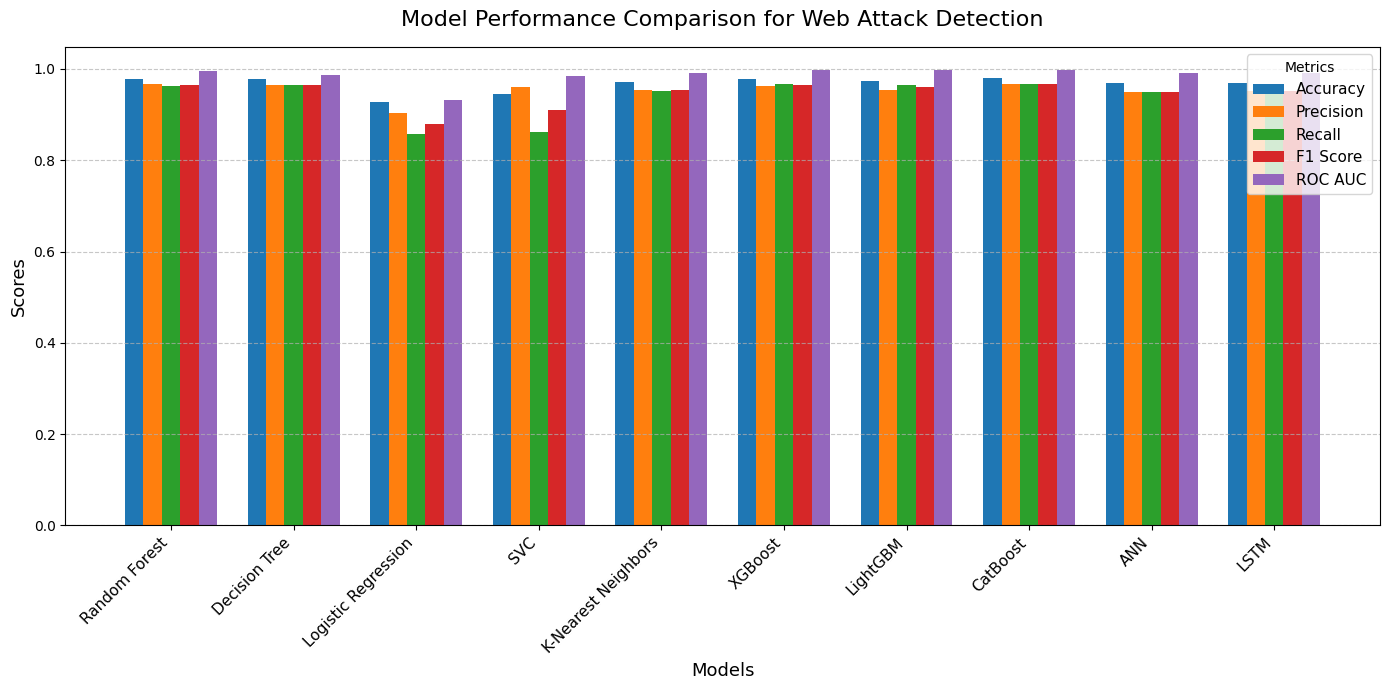

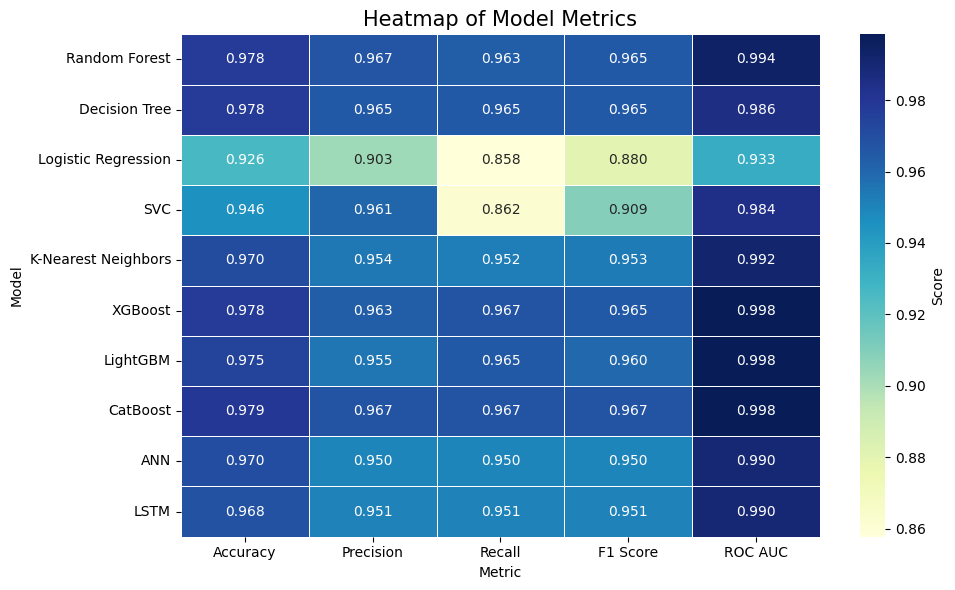

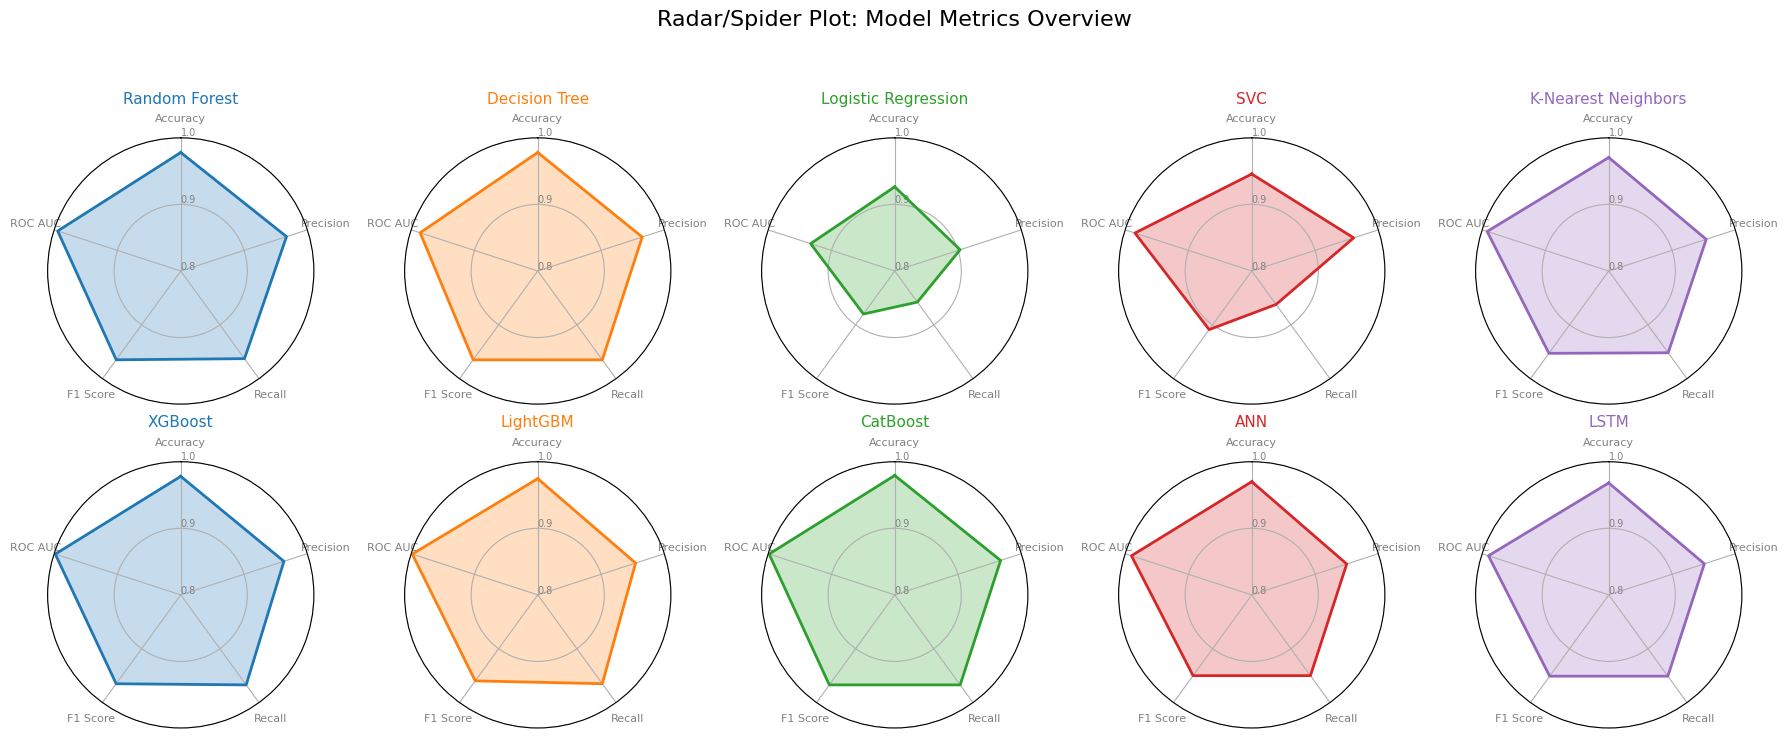

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import pi

# Data from the updated results table
data = {
    'Model': ['Random Forest', 'Decision Tree', 'Logistic Regression', 'SVC', 
              'K-Nearest Neighbors', 'XGBoost', 'LightGBM', 'CatBoost', 'ANN', 'LSTM'],
    'Accuracy': [0.977992, 0.977992, 0.92641, 0.945667, 0.970426, 0.977992, 0.974553, 0.979367, 0.97, 0.9681],
    'Precision': [0.967033, 0.964989, 0.903226, 0.960976, 0.953947, 0.962963, 0.954545, 0.967177, 0.95, 0.9510],
    'Recall': [0.962801, 0.964989, 0.857768, 0.862144, 0.95186, 0.967177, 0.964989, 0.967177, 0.95, 0.9510],
    'F1 Score': [0.964912, 0.964989, 0.87991, 0.908881, 0.952903, 0.965066, 0.959739, 0.967177, 0.95, 0.9510],
    'ROC AUC': [0.994354, 0.98575, 0.932863, 0.984451, 0.992012, 0.99815, 0.998183, 0.99841, 0.99, 0.99]
}

# Create DataFrame
df = pd.DataFrame(data)

# --- 1. Grouped Bar Plot ---
plt.figure(figsize=(14, 7))
bar_width = 0.15
index = np.arange(len(df['Model']))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, df[metric], bar_width, label=metric, color=colors[i])

plt.xlabel('Models', fontsize=13)
plt.ylabel('Scores', fontsize=13)
plt.title('Model Performance Comparison for Web Attack Detection', fontsize=16, pad=15)
plt.xticks(index + bar_width * 2, df['Model'], rotation=45, ha='right', fontsize=11)
plt.legend(title='Metrics', fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 2. Heatmap of Metrics ---
plt.figure(figsize=(10, 6))
sns.heatmap(df.set_index('Model')[metrics], annot=True, fmt='.3f', cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Score'})
plt.title('Heatmap of Model Metrics', fontsize=15)
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()

# --- 3. Radar/Spider Plot for All Models ---
def make_spider(row, title, color):
    # number of variables
    categories = list(df.columns[1:])
    N = len(categories)

    # What will be the angle of each axis in the plot?
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2, 5, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.8, 0.9, 1.0], ["0.8","0.9","1.0"], color="grey", size=7)
    plt.ylim(0.8,1.0)

    # Ind1
    values = df.loc[row].drop('Model').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.25)

    # Add a title
    plt.title(df['Model'][row], size=11, color=color, y=1.1)

plt.figure(figsize=(18, 7))
for i in range(len(df)):
    make_spider(i, df['Model'][i], colors[i % len(colors)])
plt.suptitle('Radar/Spider Plot: Model Metrics Overview', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()